# Use of financial indicators and macroeconomic fundamentals in Deep Learning  model for EM currencies trading 

In this example, we implement an FX trading algorithm based on countries' macroeconomic fundamentals and financial indicators with the help of the Deep Learning algorithm. The model trades the basket of the most liquid and traded EM currencies: Brazil, China, Colombia, Indonesia, Malaysia, Mexico, Philippines, Russia, South Africa, Thailand, and Turkey. 
The model is based on open-source libraries, it uses **FinRL** for estimation of Deep Learning model (https://github.com/AI4Finance-Foundation/FinRL), **pyfolio** for backtesting. The model was made only for educational purposes.

We use the following list of indicators for each country in order to capture its fundaments and financial position:

1. <a href='#ind1'>**Principal components to gauge the global movement in EM currencies.**</a> To capture the dynamics of the global trend in EM currencies, we use principal component analysis (PCA). We estimate the main components from daily FX prices and use the first three most important to construct a PCA index for each currency. The created index shows the effect of global factors on the currency. At the same time, the difference between the PCA index and actual price shows the impact of domestic factors.
2. <a href='#ind2'>**NEER z-score to estimate deviation from the mean.**</a>  To capture the effect of mean reversion factors, we included in the model a daily z-score of NEER  (daily NEER data used from BIS _https://www.bis.org/statistics/eer.htm?m=6%7C187_).
3. **Technical indicators to capture momentum and mean reversion.** We included several popular technical indicators based on daily prices to capture momentum and mean reversion trends: MACD, RSI 30, and CCI 30.
4. <a href='#ind4'>**Volatility adjusted implied rate to capture the carry effect.**</a> To capture the impact of rates on a country's currency, we used daily data of 3m implied forward rate adjusted for implied volatility of 3m options (the data was taken from Bloomberg)
5. <a href='#ind5'>**Dynamics of external position to capture fundamental factors.**</a> To capture the effect of the country's external position on its currency, we included the ratio of its FX reserves to its imports (monthly figures) and the ratio of the current account balance plus FDI's to nominal GDP (quarterly statistics).  
6. <a href='#ind6'>**GDP forecasts to capture growth perspectives.**</a> To capture the impact of country growth (more importantly, the growth expectation) on the currency, we included monthly consensus forecasts of GDP growth (from Bloomberg) for the next four quarters. 
7. <a href='#ind7'>**Index of geopolitical uncertainty.**</a> Last but not least, we included the index of geopolitical uncertainty into the model to capture its effect on the currency. The index is calculated according to Dario Caldara and Matteo Iacoviello methodology (monthly index counting the occurrence of words related to geopolitical tensions) and is provided by CEIC. 



### 1.1 Load libraries

In [384]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime


%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")
import itertools

pathName_FX = "C:/!Projects/DataBase/FX_BL.xlsx"
model_path = "C:/!Projects/Research projects/2021 Quant/"


### 1.2 Load daily FX prices and technical indicators

In [385]:
#Currencies to estimate: Brazil, China, Colombia, Indonesia, Malaysia, Mexico, Philippines, Russia, South Africa, Thailand, and Turkey

#Set list of currencies
fx_code =   pd.read_excel(pathName_FX, "FX_code")
curr_list = fx_code["currency"]
#Load country codes and daily prices
fx_var_list =   pd.read_excel(pathName_FX, "var_list")
fx_daily =   pd.read_excel(pathName_FX, "daily")
fx_daily.iloc[:,0] = pd.to_datetime(fx_daily.iloc[:,0], format=  "m/%d/%Y") 
fx_daily = fx_daily.set_index(fx_daily.columns[0])
fx_daily.columns = fx_var_list["name"]
fx_daily.index.name = "date"
fx_daily = fx_daily.dropna()

#load daily prices with technical indicators in long format
fx_daily_price =   pd.read_excel(model_path+"results/FX_daily.xlsx", "FX_long")
fx_daily_price.iloc[:,0] = pd.to_datetime(fx_daily_price.iloc[:,0], format=  "m/%d/%Y") 

#select countries in FX daily
fx_sel = fx_daily[fx_daily.columns[fx_daily.columns.isin(curr_list)]]
fx_sel = fx_sel.dropna()

fx_bmk = fx_daily["JP EM FX"]

### 1.3 Add financial and macro indicators

#### 1.3.1 Load PCA index and compare it with currency
<a id='ind1'></a>

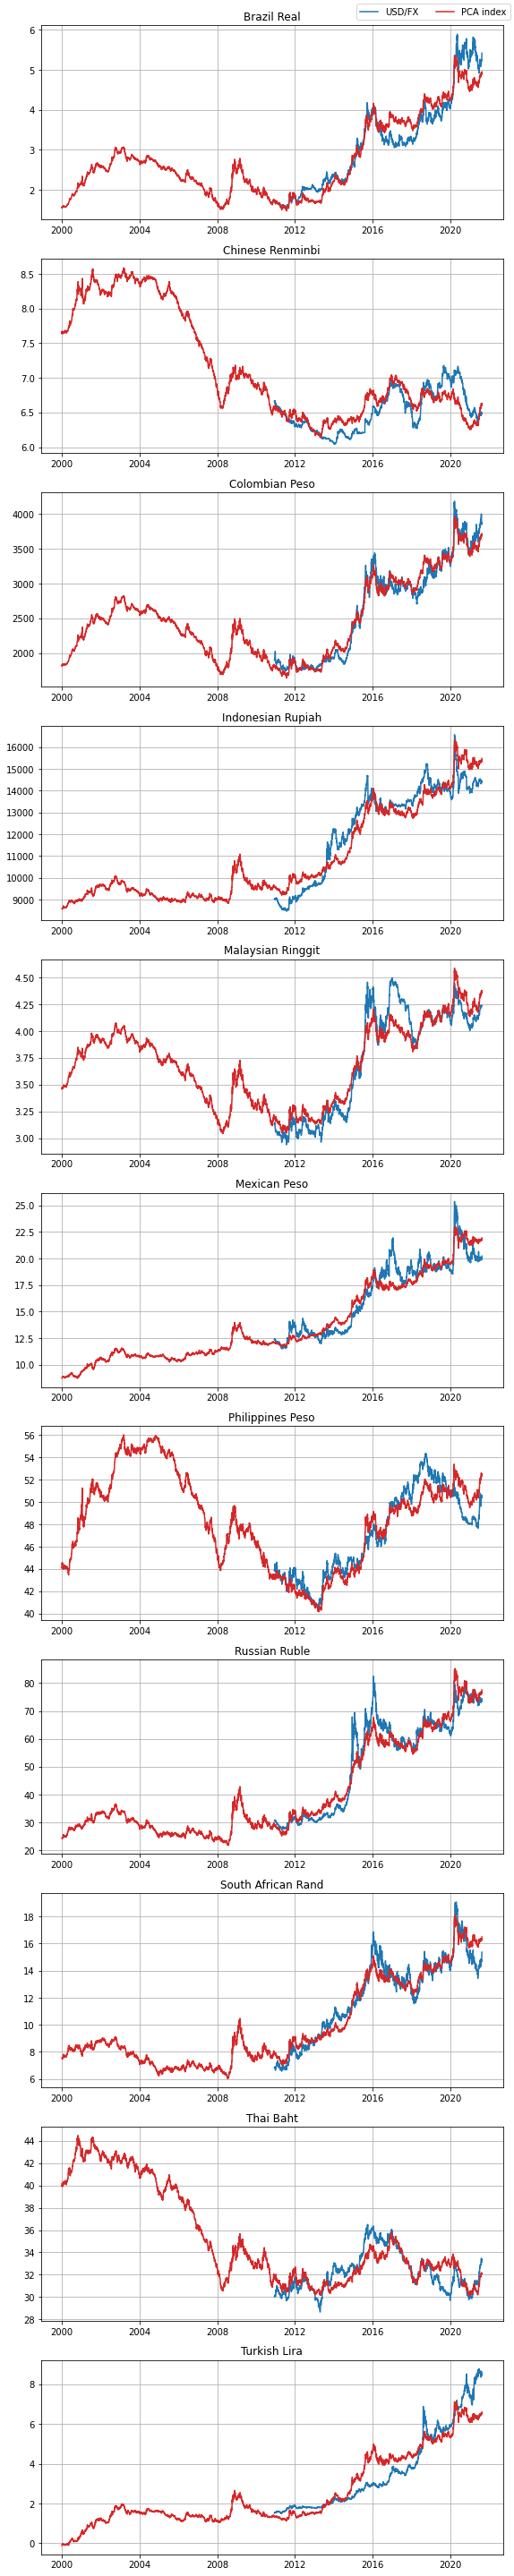

In [284]:
dta_PCA =  LoadDataFX(model_path + "/results/PCA.xlsx", "PCA",fx_code,3,3)
PlotDataFX1(fx_sel, dta_PCA, "USD/FX", "PCA index")

#### 1.3.2 Load load NEER z-score and compare it with currency
<a id='ind2'></a>

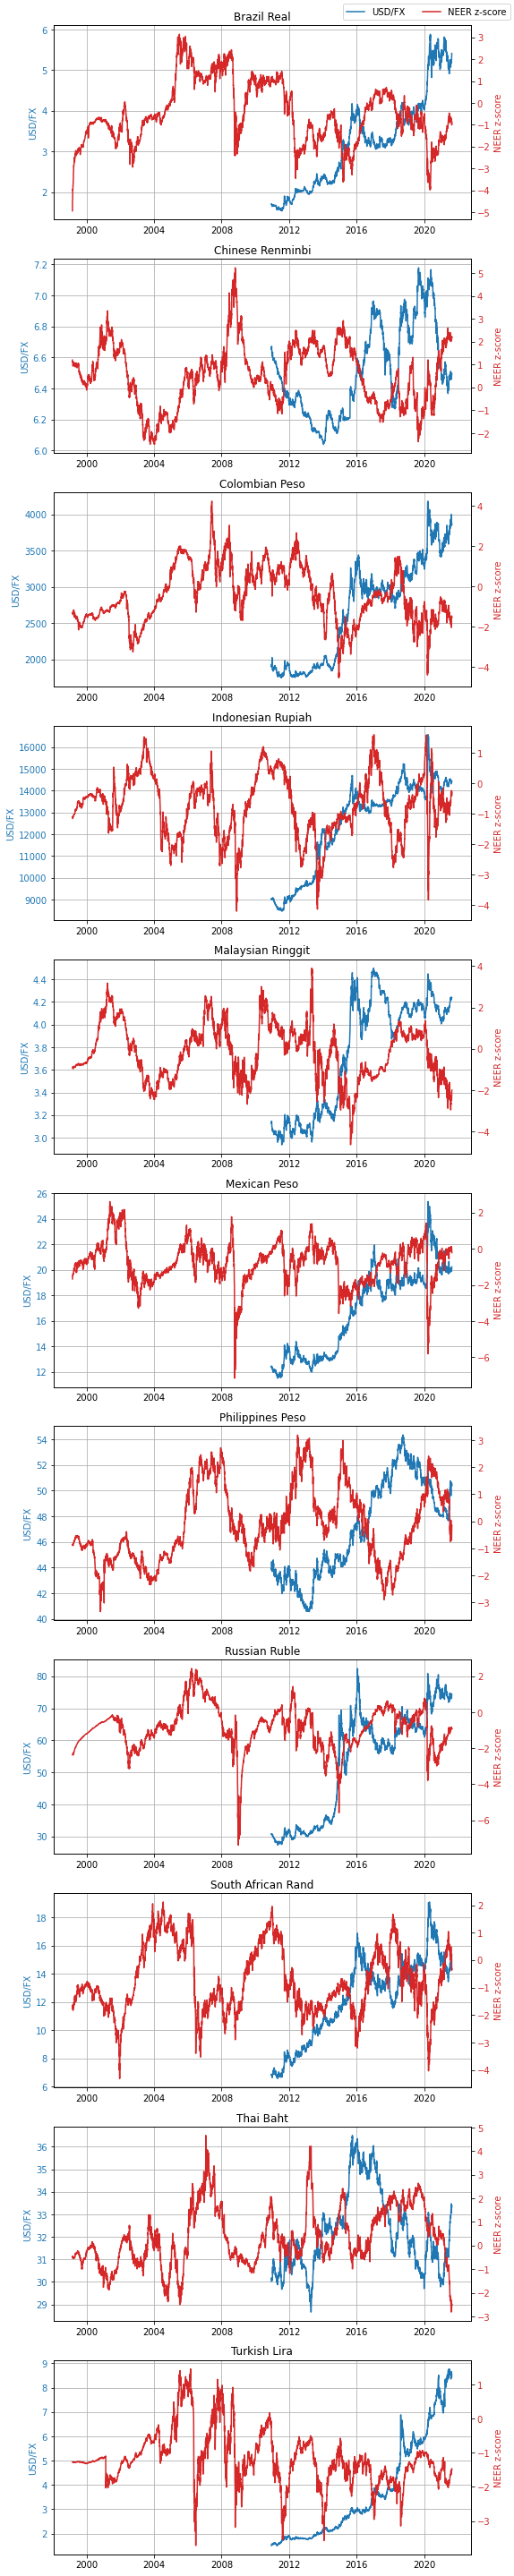

In [285]:
#load NEER z-score
dta_neer_score = LoadDataFX(model_path + "/results/NEER.xlsx", "NEER_ZS",fx_code,0,3)
PlotDataFX2(fx_sel, dta_neer_score, "USD/FX", "NEER z-score")

#### 1.3.4 Load implied rates adjusted for volatility
<a id='ind4'></a>

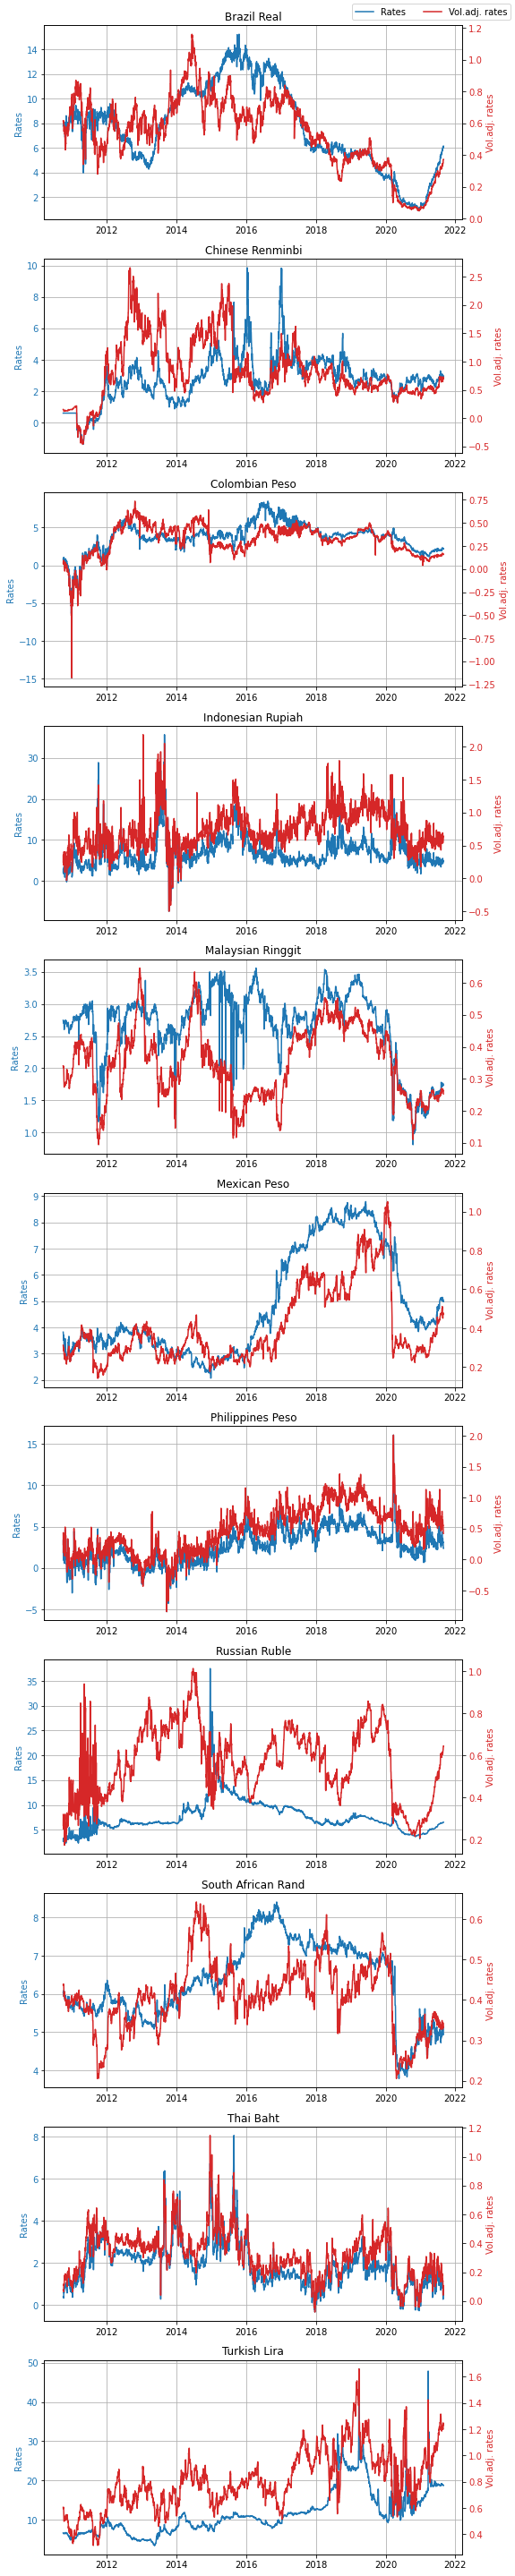

In [286]:
#load implied rates adjusted for volatility
dta_rates =  LoadDataFX(model_path + "/results/RATES.xlsx", "RATES_VADJ",fx_code,5,3)
dta_rates_sel =  LoadDataFX(model_path + "/results/RATES.xlsx", "RATES",fx_code,5,3)

PlotDataFX2(dta_rates_sel, dta_rates, "Rates", "Vol.adj. rates")

#PlotDataFX1(dta_rates_sel, dta_rates, "Rates", "Vol.adj. rates")
#PlotDataFX2(dta_rates_sel, dta_rates, "Rates", "Vol.adj. rates")

#### 1.3.5 Load FX reserves to imports and CA+FDI, % of Nominal GDP
<a id='ind5'></a>

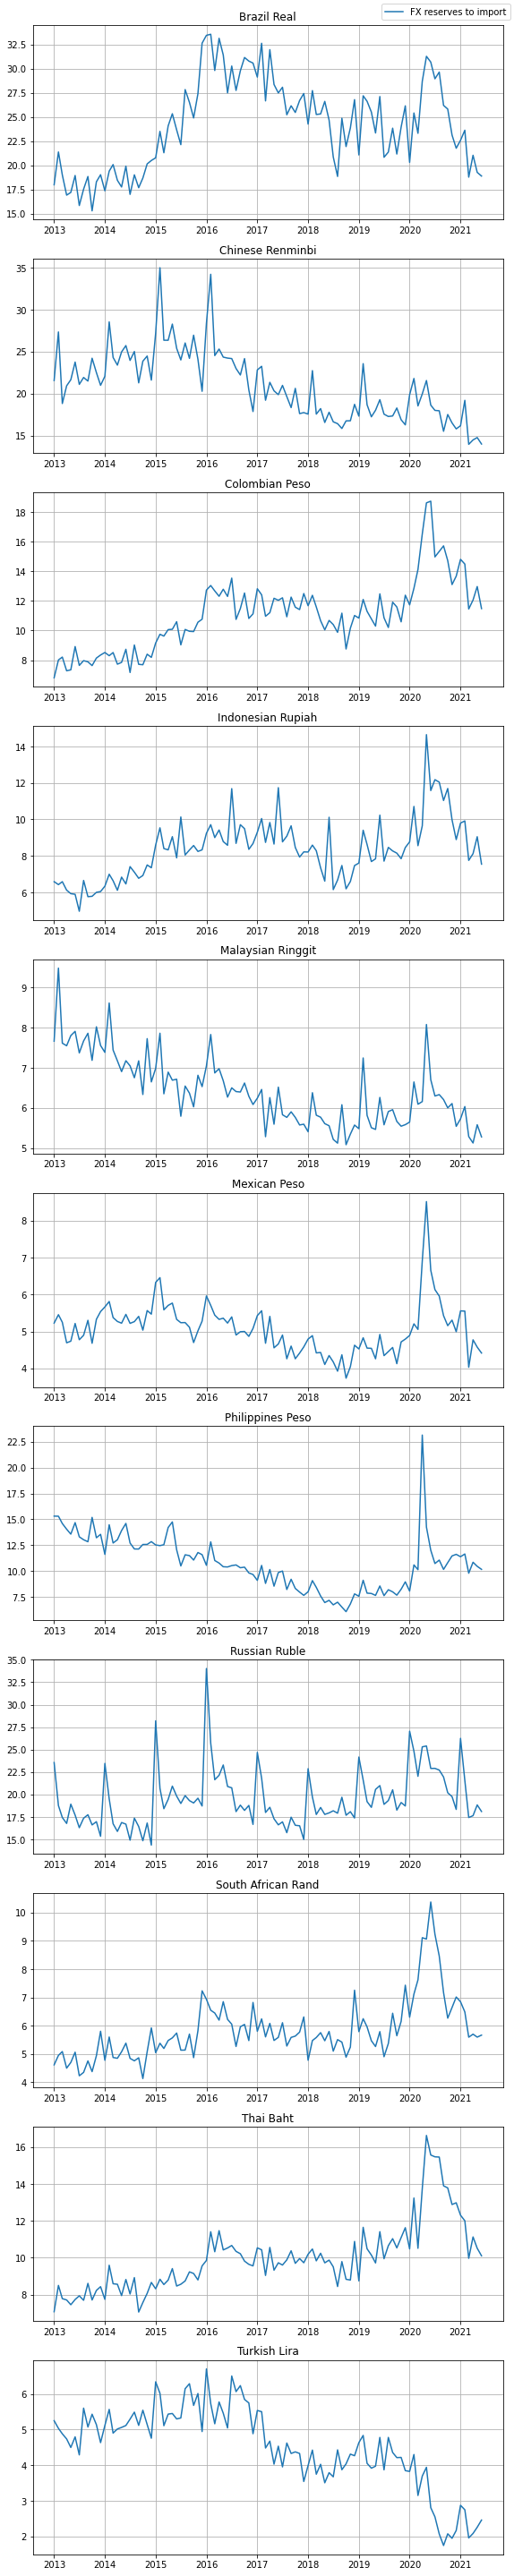

In [288]:
#load FX reserves to import ratio
dta_fxres =  LoadDataFX(model_path + "/results/FXres.xlsx", "FXRES_ratio",fx_code,2,3)
#load CA + FDI to Nominal GDP 
dta_CAratio =  LoadDataFX(model_path + "/results/CAratio.xlsx", "CA_ratio",fx_code,2,3)
PlotDataFX1(dta_fxres, fx_sel, "FX reserves to import", "",chart_type=1)

#### 1.3.6 Load monthly GDP forecasts 
<a id='ind6'></a>

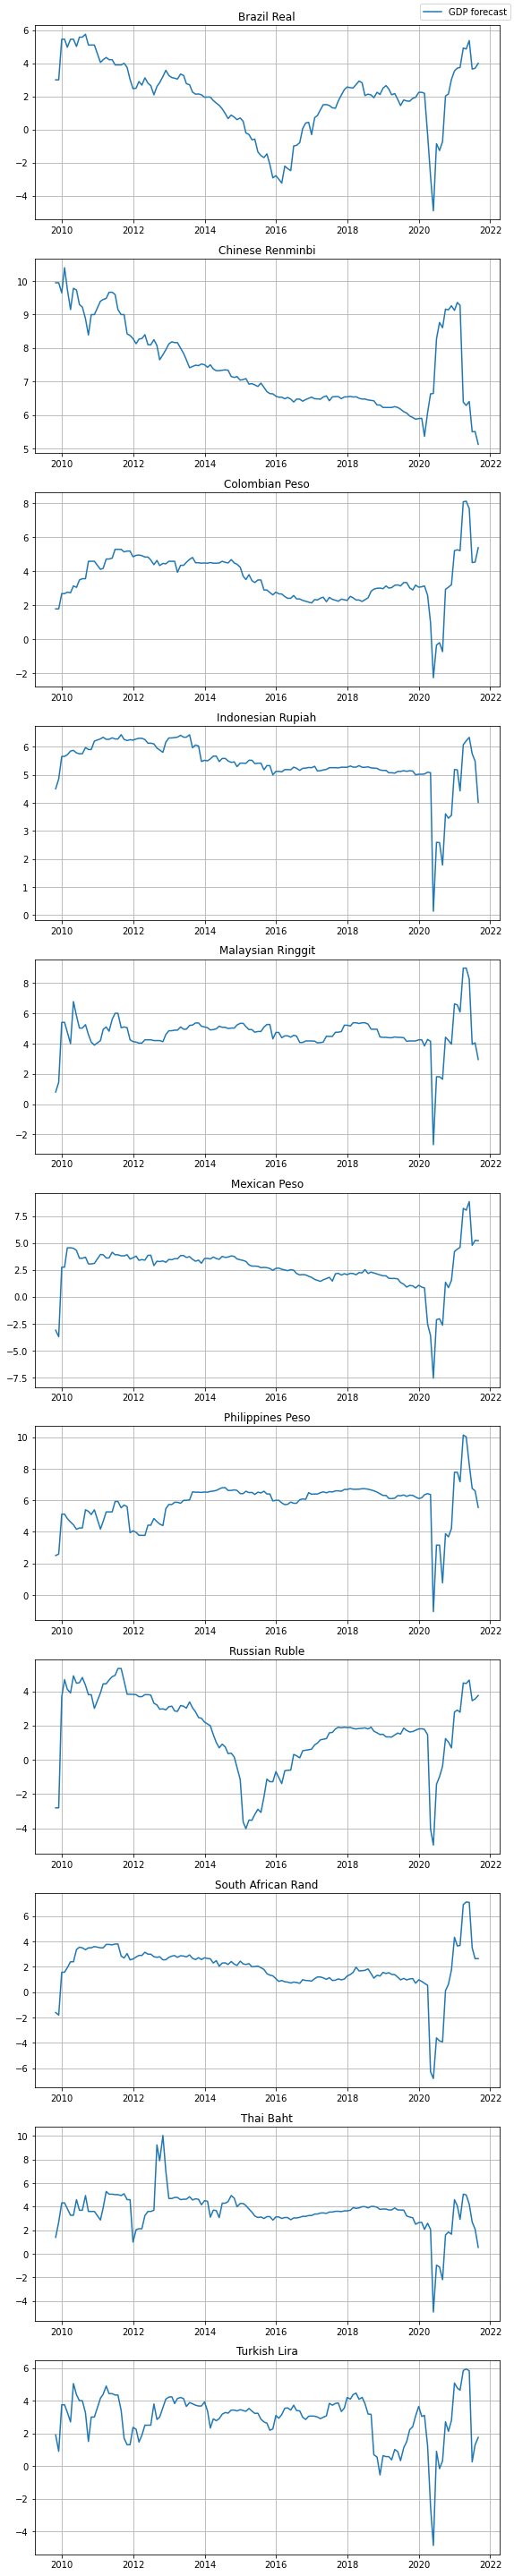

In [289]:
#load monthly GDP forecasts 
dta_GDP =  LoadDataFX(model_path + "/results/GDP_mon.xlsx", "GDP",fx_code,1,3)
PlotDataFX1(dta_GDP, fx_sel, "GDP forecast", "",chart_type=1)

#### 1.3.7 Load index of geopolitical uncertainty 
<a id='ind7'></a>

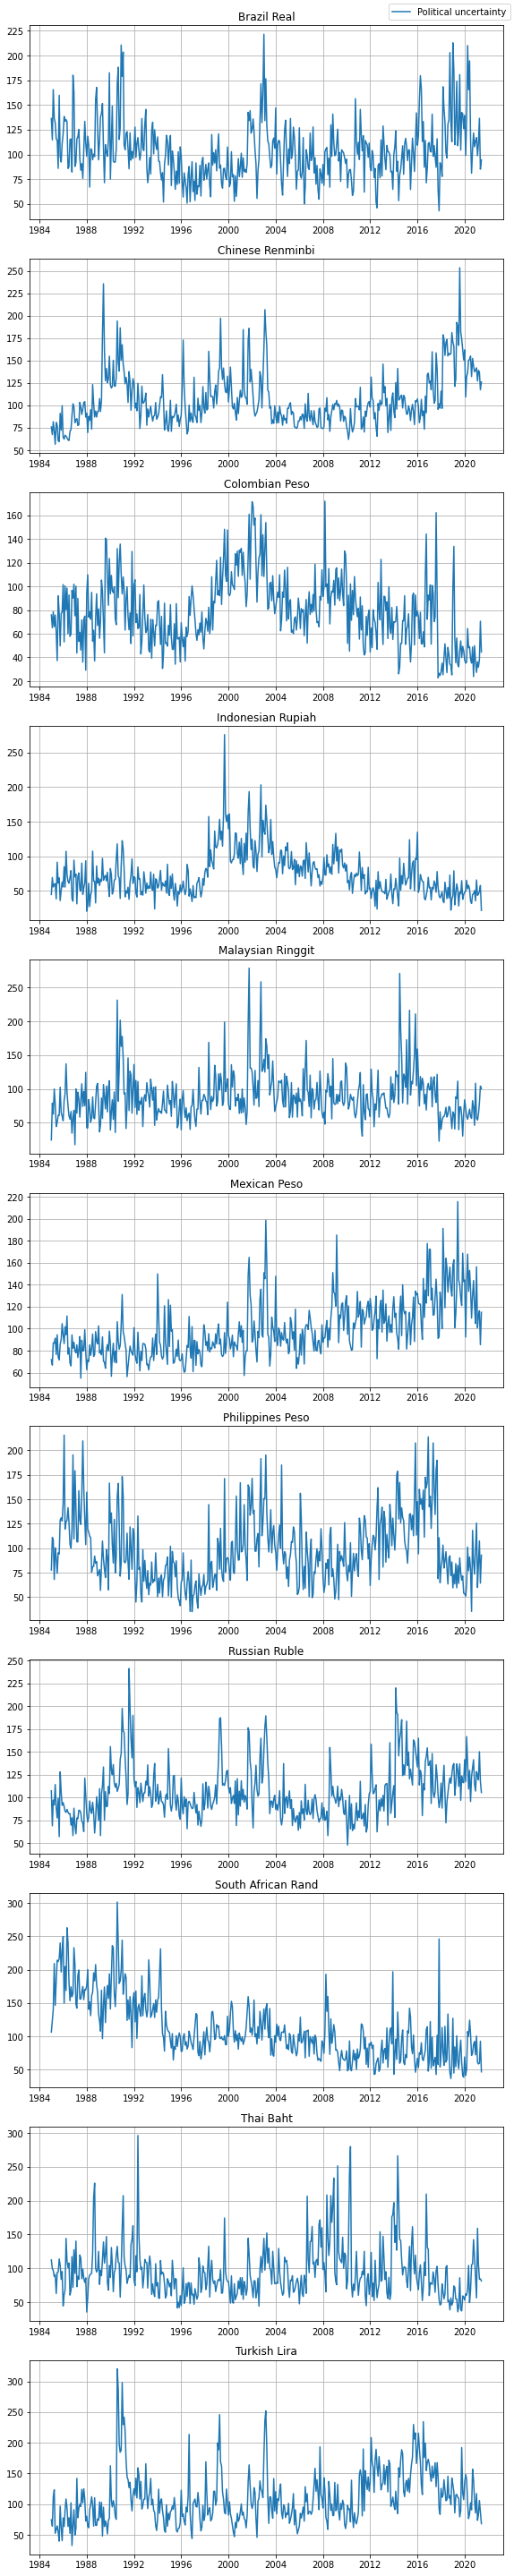

In [290]:
#load index of geopolitical uncertainty 

dta_Polit =  LoadDataFX(model_path + "/results/Polit.xlsx", "Polit",fx_code,2,3)
PlotDataFX1(dta_Polit, fx_sel, "Political uncertainty", "",chart_type=1)

### 1.4 Prepared the data for model estimation

Transform daily data into long format and add to FX daily

In [319]:
#transform into long format daily data:
X_neer = pd.melt(dta_neer_score.reset_index(), id_vars=['date'], var_name='tic', value_name='neer')
X_rates = pd.melt(dta_rates.reset_index(), id_vars=['date'], var_name='tic', value_name='rate')
X_pca = pd.melt(dta_PCA.reset_index(), id_vars=['date'], var_name='tic', value_name='pca')

#merge them to FX daily
proc_1 = fx_daily_price.merge(X_neer, how='left', on=['date','tic'])
proc_2 = proc_1.merge(X_rates, how='left', on=['date','tic'])
proc_3 = proc_2.merge(X_pca, how='left', on=['date','tic'])
#proc_3.tail()


In [325]:
#transform monthly FX reserves ratio into daily
dta_fxres_d = FillDaily(dta_fxres)
#transform quarterly CA ratio into daily
dta_CAratio_d = FillDaily(dta_CAratio)
#transform monthly GDP forecasts into daily
dta_GDP_d = FillDaily(dta_GDP)
#transform monthly political index into daily
dta_Polit_d = FillDaily(dta_Polit)


In [326]:
#transform into long format
dta_fxres_d = dta_fxres_d.reset_index()
X_fxres = pd.melt(dta_fxres_d, id_vars=['date'], var_name='tic', value_name='fxres')

dta_CAratio_d = dta_CAratio_d.reset_index()
X_CA = pd.melt(dta_CAratio_d, id_vars=['date'], var_name='tic', value_name='ca')

dta_GDP_d = dta_GDP_d.reset_index()
X_GDP = pd.melt(dta_GDP_d, id_vars=['date'], var_name='tic', value_name='dgp')

dta_Polit_d = dta_Polit_d.reset_index()
X_Polit = pd.melt(dta_Polit_d, id_vars=['date'], var_name='tic', value_name='polit')

#merge into dataset
processed_full = proc_3.merge(X_fxres, how='left', on=['date','tic'])
processed_full = processed_full.merge(X_CA, how='left', on=['date','tic'])
processed_full = processed_full.merge(X_GDP, how='left', on=['date','tic'])
processed_full = processed_full.merge(X_Polit, how='left', on=['date','tic'])
#processed_full = processed_full.dropna()

In [342]:
processed_full = processed_full.sort_values(['tic','date'])
processed_full = processed_full.dropna()
processed_full.tail()

,date,tic,close,open,high,low,volume,amount,macd,rsi_30,cci_30,turbulence,neer,rate,pca,fxres,ca,dgp,polit
93047,2021-03-25,Turkish Lira,7.9446,0,0,0,0,0,0.117051,63.945609,195.565116,23.845361,-1.706159,0.955725,6.428050,2.746324,-0.025285,4.65,73.636251
93059,2021-03-26,Turkish Lira,8.1076,0,0,0,0,0,0.145734,66.888004,236.563785,17.235425,-1.722535,0.944118,6.479487,2.746324,-0.025285,4.65,73.636251
93095,2021-03-29,Turkish Lira,8.2104,0,0,0,0,0,0.198380,68.672998,175.326743,13.417691,-1.802382,1.046372,6.491384,2.746324,-0.025285,4.65,73.636251
93107,2021-03-30,Turkish Lira,8.3360,0,0,0,0,0,0.219792,70.671313,181.284522,9.466018,-1.882089,1.123790,6.511638,2.746324,-0.025285,4.65,73.636251
93119,2021-03-31,Turkish Lira,8.2519,0,0,0,0,0,0.227354,67.680837,141.432780,18.461586,-1.860795,0.884410,6.422028,1.955297,-0.028936,5.85,82.566777


In [343]:
fileSave = model_path + "/results/Processed_full.xlsx"
with pd.ExcelWriter(fileSave) as writer:  
    processed_full.to_excel(writer, sheet_name='data')
     
#manually shifted dates by one month 

## 2. Model description

We used constructed indicators to estimate the neural network model, which makes trading decisions. Such kind of problem is called reinforcement learning (RL). A typical RL algorithm has a decision-maker (in our case is a trader), which acts in the surrounding environment. In our model, the environment space contains information about prices, macro fundaments, financial indicators, and other information, which is available for the agent when he makes the decision. Reinforcement learning algorithm rewards the trader, whether positive or negative, based on his actions. This model implements two Markov Decision Process algorithms estimated with neutral networks (in Deep Reinforcement Learning, the agent is represented by a neural network). The first algorithm is Twin Delayed Deep Deterministic Policy algorithm (TD3 and its version DDPG). Another one is entropy-regularized Reinforcement Learning algorithm SAC (Soft Actor Critic). Both algorithms are estimated with FinLR package (based on OpenAI Baselines library).  


### 2.1 Split data into training and trade dataset
- Training data split: 213-01-01 to 2018-12-31
- Trade data split: 2019-01-01 to 2021-07-01

In [346]:
train = data_split(processed_full, '2013-01-01','2019-01-01')
trade = data_split(processed_full, '2019-01-01','2021-07-01')
# Check the length of the two datasets
print("Train sample: " + str(len(train)))
print("Test sample: " + str(len(trade)))

Train sample: 16973
Test sample: 6457


### 2.2 Set parameters of the model
Set parameters for the environment

In [347]:
#full list of indicators:
ratio_list = ["macd","rsi_30","cci_30","neer","rate","pca","fxres","ca","dgp","polit"] 

fx_dimension = len(train.tic.unique())
state_space = 1 + 2*fx_dimension + len(ratio_list)*fx_dimension
print(f"FX Dimension: {fx_dimension}, State Space: {state_space}")

# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": fx_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": fx_dimension, 
    "reward_scaling": 1e-4
    
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

FX Dimension: 11, State Space: 133


### 2.3 Set environment for training



In [349]:
## run cycle:
ri = "1est"

env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

# Set up the agent using DRLAgent() class using the environment
agent = DRLAgent(env = env_train)

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


#### 2.3.1 Model DDPG
Estimate model on training sample

In [350]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

trained_ddpg.save(model_path+"ddpg_"+ri+".model")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/ddpg\ddpg_7
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 35       |
|    time_elapsed    | 174      |
|    total timesteps | 6172     |
| train/             |          |
|    actor_loss      | 261      |
|    critic_loss     | 2.52e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 4629     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 32       |
|    time_elapsed    | 384      |
|    total timesteps | 12344    |
| train/             |          |
|    actor_loss      | 105      |
|    critic_loss     | 76       |
|    learning_rate   | 0.001    |
|    n_updates       | 10801    |
---------------------------------
day: 1542, episode: 10
begin_total_asset: 1000000.00
end_total

#### 2.3.2 Model TD3

In [351]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

trained_td3.save(model_path + "td3_"+ri+".model")


{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to tensorboard_log/td3\td3_4
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 40        |
|    time_elapsed    | 151       |
|    total timesteps | 6172      |
| train/             |           |
|    actor_loss      | -1.26e+03 |
|    critic_loss     | 1.12e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 4629      |
----------------------------------
day: 1542, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 1233455.28
total_reward: 233455.28
total_cost: 999.00
total_trades: 6168
Sharpe: 0.588
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 35        |
|    time_elapsed    | 343       |
|    total timesteps | 12344     |
| train/             |           |
|    actor_loss      | -1.53e+03 |
|    critic_loss     

#### 2.3.3 Model SAC

In [352]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=80000)
trained_sac.save(model_path + "sac_"+ri+".model")

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_9
day: 1542, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 1905157.21
total_reward: 905157.21
total_cost: 1737.22
total_trades: 9369
Sharpe: 0.799
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 23       |
|    time_elapsed    | 263      |
|    total timesteps | 6172     |
| train/             |          |
|    actor_loss      | 2.09e+03 |
|    critic_loss     | 1.19e+03 |
|    ent_coef        | 0.182    |
|    ent_coef_loss   | 253      |
|    learning_rate   | 0.0001   |
|    n_updates       | 6071     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 24       |
|    time_elapsed    | 500      |
|    total timesteps | 12

## 3. Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the SAC model to trade EM FX currencies (DDPG and TD3 are also available)

### 3.1 Make backtest on training sample with estimated SAC model

Use SAC model

In [415]:
train = data_split(processed_full, '2013-01-01','2019-01-01')
trade = data_split(processed_full, '2019-01-01','2021-07-01')

hit end!
==============Get Backtest Results===========
Annual return          0.112023
Cumulative returns     0.915822
Annual volatility      0.145028
Sharpe ratio           0.805027
Calmar ratio           0.375952
Stability              0.631189
Max drawdown          -0.297971
Omega ratio            1.163808
Sortino ratio          1.224550
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.114365
Daily value at risk   -0.017808
dtype: float64


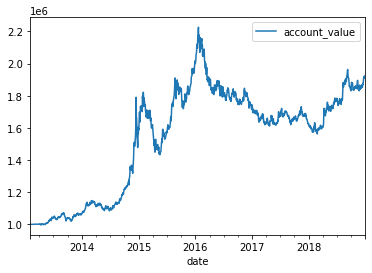

In [416]:
#use SAC model with training sample
e_trade_gym = StockTradingEnv(df = train, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

df_account_value.plot(x="date", y="account_value")
#df_account_value.tail()

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

fileSave = model_path + "/results/tr_back_"+ri+".xlsx"
with pd.ExcelWriter(fileSave) as writer:  
    df_account_value.to_excel(writer, sheet_name='account')
    df_actions.to_excel(writer, sheet_name='actions')
    perf_stats_all.to_excel(writer, sheet_name='stats')


### 3.2 Test results against the benchmark on traing sample
Use buy and hold strategy of JPM EM FX index as a benchmark to compare with model trading results


Start date,2013-01-31
End date,2018-12-31
Total months,73
,Backtest
Annual return,11.202%
Cumulative returns,91.582%
Annual volatility,14.503%
Sharpe ratio,0.81
Calmar ratio,0.38
Stability,0.63
Max drawdown,-29.797%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.80,2016-01-21,2018-02-26,NaT,NaN
1,21.35,2015-01-30,2015-05-18,2015-08-20,145
2,17.42,2014-12-16,2014-12-25,2015-01-26,30
3,10.02,2015-08-24,2015-10-15,2015-12-07,76
4,5.55,2014-03-03,2014-06-27,2014-08-29,130


Stress Events,mean,min,max
Apr14,0.03%,-0.85%,0.67%
Oct14,0.21%,-2.24%,2.75%
Fall2015,0.08%,-3.22%,2.93%
New Normal,0.05%,-6.98%,7.62%


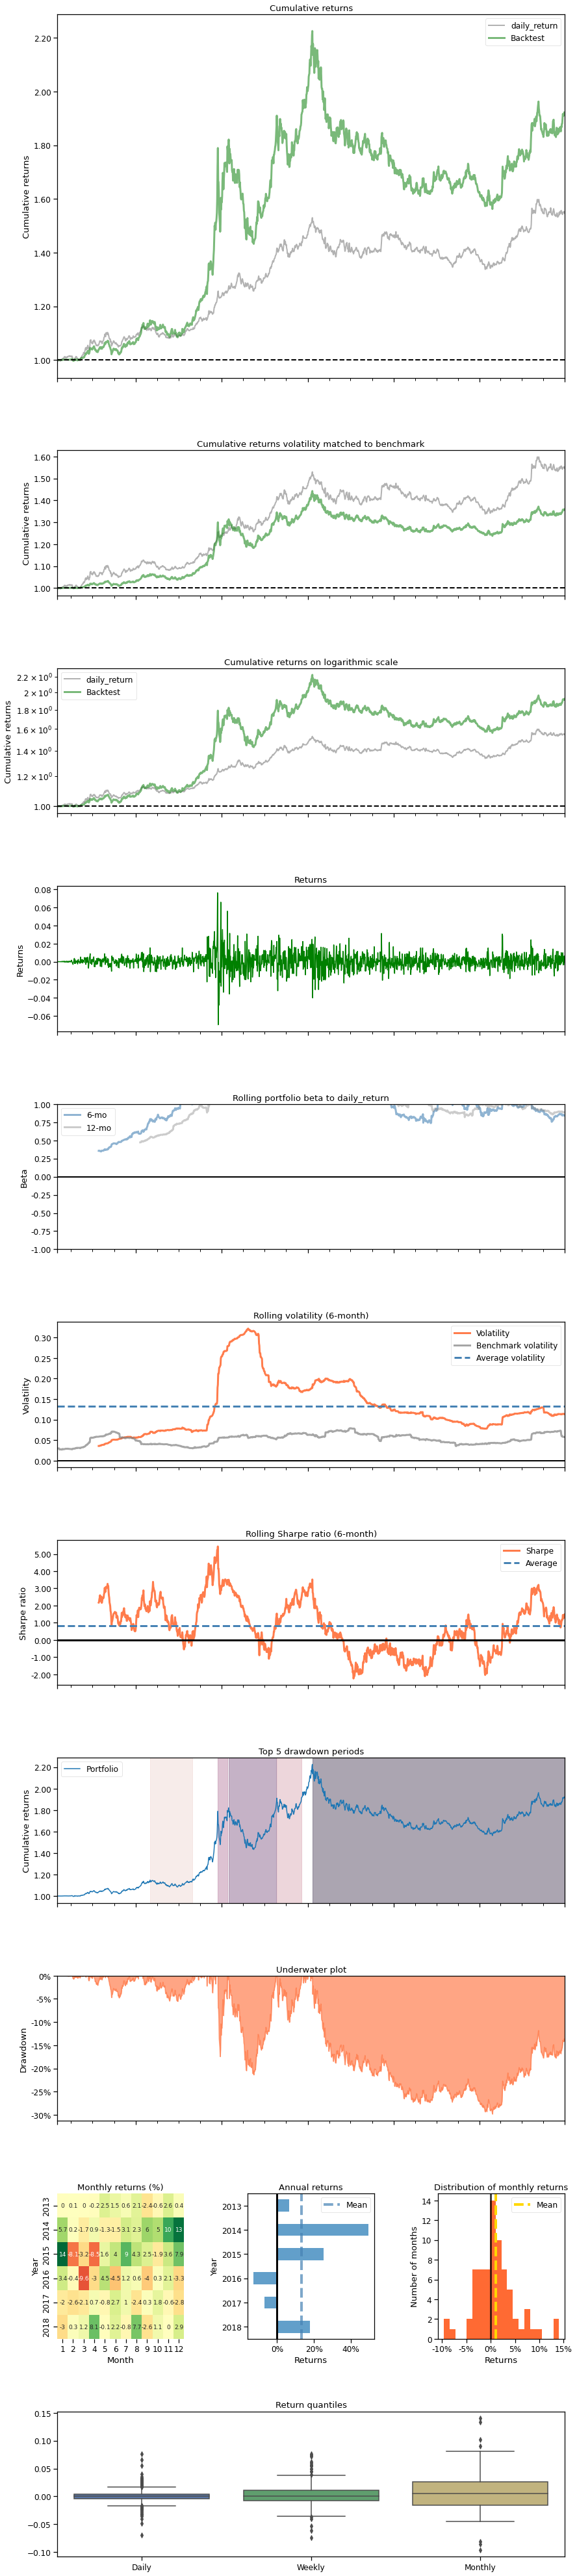

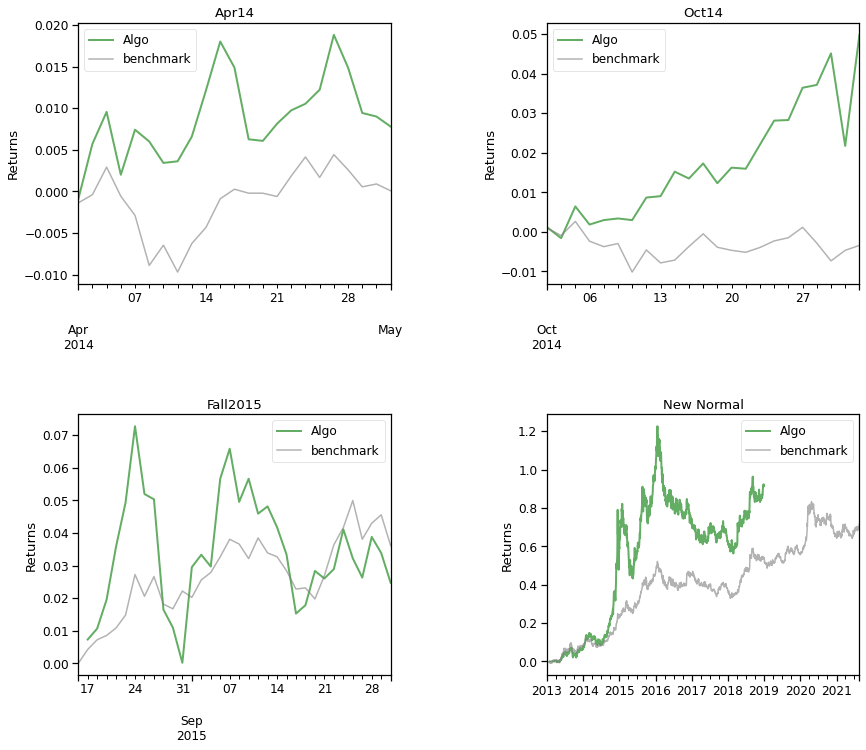

In [417]:
#Use JPM EM FX index (from Bloomberg)
fx_bmk2 = fx_bmk.rdiv(1)
backtest_plot2(df_account_value, 
             fx_bmk2, 
             baseline_start = '2013-01-01',
             baseline_end = '2019-01-01')


### 3.3 Make backtest on test sample with estimated SAC model

Use SAC model

hit end!
==============Get Backtest Results===========
Annual return          0.050017
Cumulative returns     0.120403
Annual volatility      0.115830
Sharpe ratio           0.479368
Calmar ratio           0.441735
Stability              0.586260
Max drawdown          -0.113229
Omega ratio            1.096686
Sortino ratio          0.806953
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.236479
Daily value at risk   -0.014373
dtype: float64


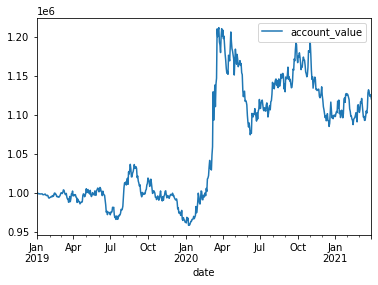

In [418]:
#use SAC model with training sample
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

df_account_value.plot(x="date", y="account_value")
#df_account_value.tail()

print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

fileSave = model_path + "/results/tr_back_"+ri+".xlsx"
with pd.ExcelWriter(fileSave) as writer:  
    df_account_value.to_excel(writer, sheet_name='account')
    df_actions.to_excel(writer, sheet_name='actions')
    perf_stats_all.to_excel(writer, sheet_name='stats')


### 3.4 Test results against the benchmark on test sample
Use buy and hold strategy of JPM EM FX index as a benchmark to compare with model trading results


Start date,2019-01-01
End date,2021-03-31
Total months,27
,Backtest
Annual return,5.002%
Cumulative returns,12.04%
Annual volatility,11.583%
Sharpe ratio,0.48
Calmar ratio,0.44
Stability,0.59
Max drawdown,-11.323%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.32,2020-03-23,2020-06-08,NaT,NaN
1,7.54,2019-08-19,2020-01-08,2020-02-28,140
2,4.06,2019-06-05,2019-07-15,2019-08-05,44
3,3.22,2020-03-09,2020-03-10,2020-03-12,4
4,2.43,2020-03-12,2020-03-13,2020-03-16,3


Stress Events,mean,min,max
New Normal,0.02%,-3.22%,6.64%


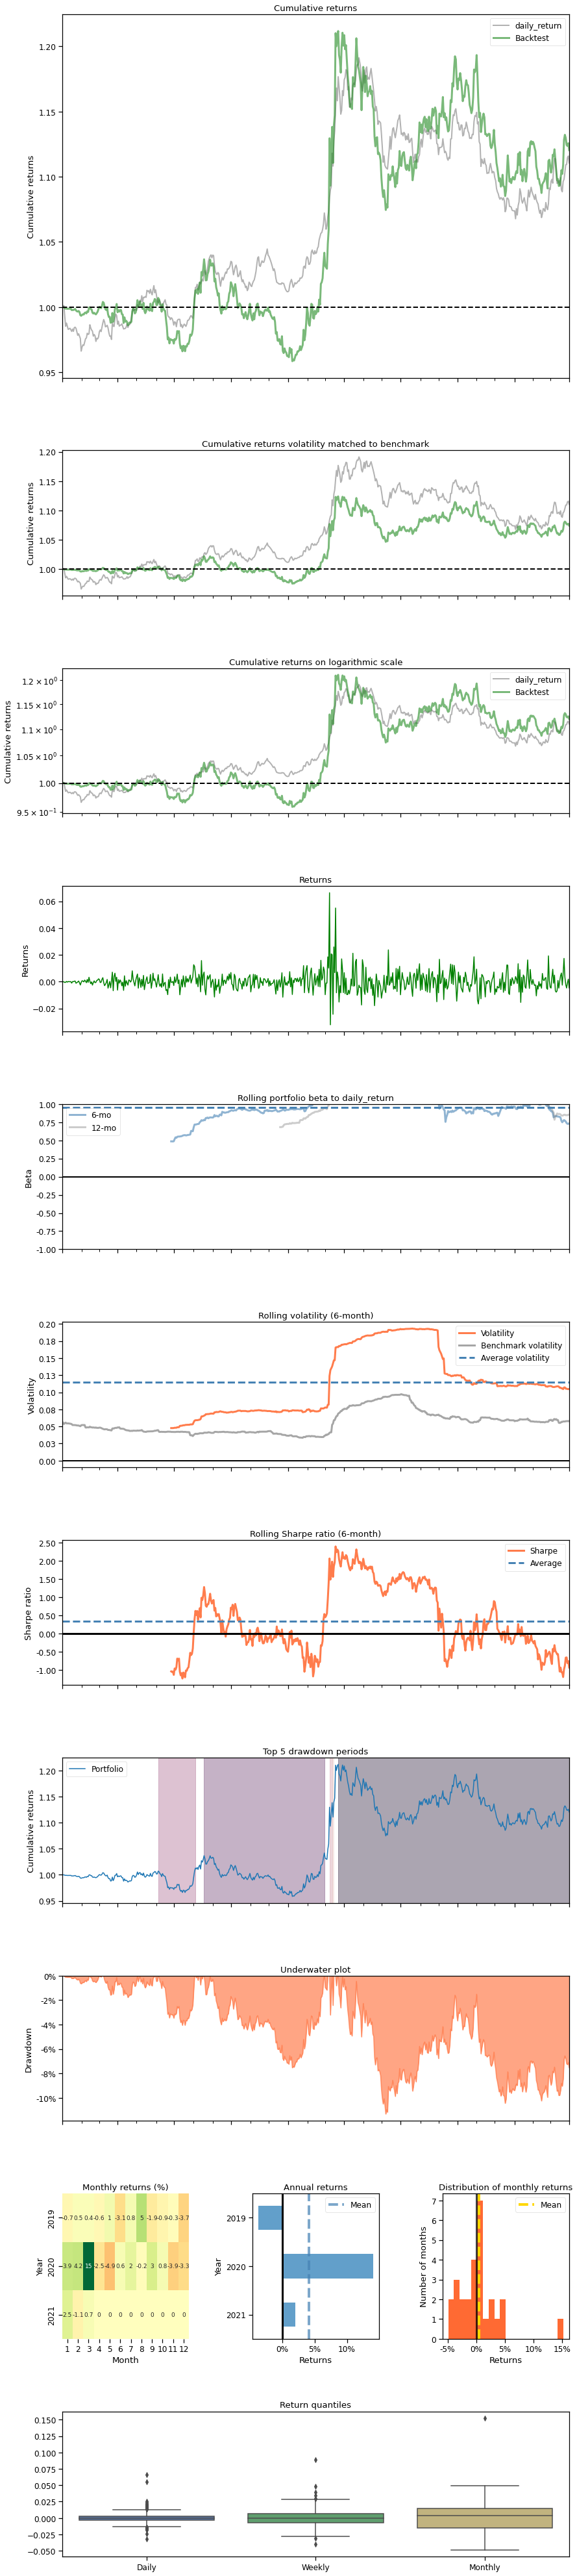

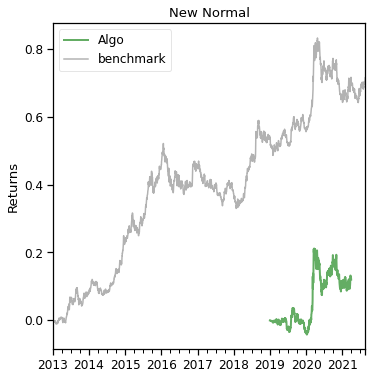

In [419]:
#Use JPM EM FX index (from Bloomberg)
fx_bmk2 = fx_bmk.rdiv(1)
backtest_plot2(df_account_value, 
             fx_bmk2, 
             baseline_start = '2019-01-01',
             baseline_end = '2021-07-01')

### Some additional functions

In [383]:
def LoadDataFX(FilePath, sheet,  country_code, type_from, type_to, dt_format = "m/%d/%Y"):
    #load data

    dta =   pd.read_excel(FilePath, sheet)
    #transform to date format
    dta.iloc[:,0] = pd.to_datetime(dta.iloc[:,0], format =  dt_format) 
    #set index
    dta = dta.set_index(dta.columns[0])
    dta.index.name = "date"
    #type_from types of headers: 0 - iso2, 1- country1, 2 - country, 3-currency full, 4-BL tiker, 5-shirt name
        
    dta_sel = pd.DataFrame()
    for i, (name, row) in enumerate(country_code.iterrows()):
        dta_sel[row[type_to]] = dta[row[type_from]]  # iso2 header
    dta_sel = dta_sel.dropna()
    
    return dta_sel

#plot two lines on single ax 
def PlotDataFX1(ind_dta1, ind_dta2, ind_name1, ind_name2, chart_type=2):
    fig, axes = plt.subplots(len(ind_dta1.columns), figsize=[8,40])
    axe = axes.ravel()
    i=0
    for s in ind_dta1.columns:
        axe[i].set_title(s)
        axe[i].plot(ind_dta1.index, ind_dta1[s], label=('', '_')[i>0] + ind_name1, color='tab:blue')
        if(chart_type == 2):
            axe[i].plot(ind_dta2.index, ind_dta2[s], label=('', '_')[i>0] + ind_name2, color= 'tab:red')
        axe[i].grid()
        #axe[i].tick_params(axis='y', labelcolor=color)
        #axe[i].set_ylabel('', color=color)
        #second y-axis
        i = i+1
    fig.tight_layout()  
    fig.legend(loc=1, ncol=3)
    plt.show()
    
#plot two lines on different ax 
def PlotDataFX2(ind_dta1, ind_dta2, ind_name1, ind_name2):
    fig, axes = plt.subplots(len(ind_dta1.columns), figsize=[8,40])
    axe = axes.ravel()
    i=0
    for s in ind_dta1.columns:
        axe[i].set_title(s)
        color = 'tab:blue'
        axe[i].plot(ind_dta1.index, ind_dta1[s], label=('', '_')[i>0] + ind_name1, color=color)
        axe[i].set_ylabel(ind_name1, color=color)
        axe[i].tick_params(axis='y', labelcolor=color)
        axe[i].grid()
        #axe[i].tick_params(axis='y', labelcolor=color)
        #axe[i].set_ylabel('', color=color)
        #second y-axis
        ax2 = axe[i].twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        ax2.set_ylabel(ind_name2, color=color)  # we already handled the x-label with ax1
        ax2.plot(ind_dta2.index, ind_dta2[s], label=('', '_')[i>0] + ind_name2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        i = i+1
    fig.tight_layout()  
    fig.legend(loc=1, ncol=3)
    plt.show()

#interpolate  monthly and quarterly data into daily
def FillDaily(df):
    df.index = df.index.to_period('M').to_timestamp('M')
    start_date = df.index.min() - pd.DateOffset(day=1)
    end_date = df.index.max() + pd.DateOffset(day=31)
    
    dates = pd.date_range(start_date, end_date, freq='D')
    dates.name = 'date'
    df = df.reindex(dates, method='ffill')
    return df
    #print(df)

    
import pandas as pd
import numpy as np

from pyfolio import timeseries
import pyfolio
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from copy import deepcopy

from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.apps import config

def backtest_plot2(
    account_value,
    baseline_index,
    baseline_start=config.START_TRADE_DATE,
    baseline_end=config.END_DATE,
    value_col_name="account_value",
    ):

    df = deepcopy(account_value)
    test_returns = get_daily_return(df, value_col_name=value_col_name)

    #baseline_df = get_baseline(
    #    ticker=baseline_ticker, start=baseline_start, end=baseline_end
    #)

    baseline_df = pd.melt(baseline_index.reset_index(), id_vars=['date'], var_name='tic', value_name='close')
    baseline_df["open"] = 0
    baseline_df["high"] = 0
    baseline_df["low"] = 0
    baseline_df["volume"] = 0
    baseline_df["day"] = 0
      
    baseline_returns = get_daily_return(baseline_df, value_col_name="close")
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
    )